In [1]:
%load_ext Cython

In [2]:
import numpy as np
import pulse2percept as p2p
%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-03-26 13:46:18,376 [pulse2percept] [INFO] Welcome to pulse2percept


In [3]:
class LegacyNanduri2012(p2p.retina.Nanduri2012):
    """Preserve old implementation to make sure Cython model runs correctly"""

    def model_cascade(self, in_arr, pt_list, layers, use_jit):
        """Nanduri model cascade

        Parameters
        ----------
        in_arr: array - like
            A 2D array specifying the effective current values
            at a particular spatial location(pixel); one value
            per retinal layer and electrode.
            Dimensions: <  # layers x #electrodes>
        pt_list: list
            List of pulse train 'data' containers.
            Dimensions: <  # electrodes x #time points>
        layers: list
            List of retinal layers to simulate.
            Choose from:
            - 'OFL': optic fiber layer
            - 'GCL': ganglion cell layer
        use_jit: bool
            If True, applies just - in-time(JIT) compilation to
            expensive computations for additional speed - up
            (requires Numba).
        """
        if 'INL' in layers:
            raise ValueError("The Nanduri2012 model does not support an inner "
                             "nuclear layer.")

        # Although the paper says to use cathodic-first, the code only
        # reproduces if we use what we now call anodic-first. So flip the sign
        # on the stimulus here:
        b1 = -self.calc_layer_current(in_arr, pt_list, layers)

        # Fast response
        b2 = self.tsample * p2p.utils.conv(b1, self.gamma1, mode='full',
                                           method='sparse',
                                           use_jit=use_jit)[:b1.size]

        # Charge accumulation
        ca = self.tsample * np.cumsum(np.maximum(0, b1))
        ca = self.tsample * p2p.utils.conv(ca, self.gamma2, mode='full',
                                           method='fft')[:b1.size]
        b3 = np.maximum(0, b2 - self.eps * ca)

        # Stationary nonlinearity
        b3max = b3.max()
        sigmoid = ss.expit((b3max - self.shift) / self.slope)
        b4 = b3 / b3max * sigmoid * self.asymptote

        # Slow response
        b5 = self.tsample * p2p.utils.conv(b4, self.gamma3, mode='full',
                                           method='fft')[:b1.size]

        return p2p.utils.TimeSeries(self.tsample, b5)

In [4]:
%%cython

import numpy as np
cimport numpy as np
import scipy.special as ss
import cython

cdef inline float float_max(float a, float b): return a if a >= b else b
DTYPE = np.float
ctypedef np.float_t DTYPE_t

def cythoncascade(stim, model, maxR3=99.8873446571, skip_i=0):
    cdef float tmp_chargeacc = 0
    cdef float tmp_ca = 0
    cdef float tmp_cl = 0
    cdef float tmp_R1 = 0
    cdef float tmp_R2 = 0
    cdef float tmp_R3norm = 0
    cdef float dt = stim.tsample
    cdef np.ndarray[DTYPE_t] stimdata = stim.data
    
    cdef float tmp_R3 = 0
    cdef float sc_fac = 0
    
    tmp_R4a = [0, 0, 0, 0]
    cdef np.ndarray[DTYPE_t] out_t = np.arange(0, stim.duration, stim.tsample, dtype=DTYPE)
    cdef np.ndarray[DTYPE_t] out_R4 = np.zeros_like(out_t, dtype=DTYPE)
    
    cdef float tau1 = model.tau1
    cdef float tau2 = model.tau2
    cdef float tau3 = model.tau3
    cdef float asymptote = model.asymptote
    cdef float shift = model.shift
    cdef float slope = model.slope

    for i in range(len(out_t)):
        tmp_R1 += dt * (-stimdata[i] - tmp_R1) / tau1

        # leaky integrated charge accumulation
        tmp_chargeacc += dt * float_max(stimdata[i], 0)
        tmp_ca += dt * (tmp_chargeacc - tmp_ca) / tau2
        tmp_R3 = float_max(tmp_R1 - model.eps * tmp_ca, 0)

        # nonlinearity
        sc_fac = asymptote * ss.expit((maxR3 - shift) / slope)
        
        # R4: R3 passed through a cascade of 3 leaky integrators
        tmp_R4a[0] = tmp_R3b = tmp_R3 / maxR3 * sc_fac
        for j in range(3):
            dR4a = dt * (tmp_R4a[j] - tmp_R4a[j + 1]) / tau3
            tmp_R4a[j + 1] += dR4a

        out_R4[i] = tmp_R4a[-1]
        
    return out_t, out_R4

### Model output

In [5]:
tsample = 0.005 / 1000
stim = p2p.stimuli.PulseTrain(tsample, freq=20, amp=150, pulse_dur=0.45 / 1000, dur=0.5)
layers = ['GCL']
use_jit = True

nanduri = p2p.retina.Nanduri2012(tsample=tsample)
nanduri_out = nanduri.model_cascade(np.array([1, 1]).reshape((2, 1)), stim.data, layers, use_jit)
nanduri_t = tsample * np.arange(len(nanduri_out.data))

legacy = LegacyNanduri2012(tsample=tsample)
legacy_out = legacy.model_cascade(np.array([1, 1]).reshape((2, 1)), stim.data, layers, use_jit)
legacy_t = tsample * np.arange(len(legacy_out.data))

In [6]:
cython_t, cython_out = cythoncascade(stim, nanduri)

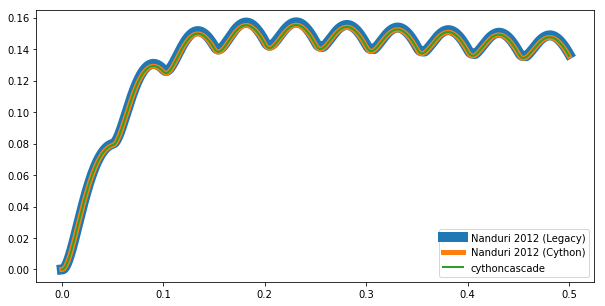

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(legacy_t, legacy_out.data, linewidth=10, label='Nanduri 2012 (Legacy)')
plt.plot(nanduri_t, nanduri_out.data, linewidth=5, label='Nanduri 2012 (Cython)')
plt.plot(cython_t, cython_out, linewidth=2, label='cythoncascade')
plt.legend(loc='lower right')

### Accuracy

In [8]:
np.allclose(legacy_out.data, nanduri_out.data, atol=5e-3)

True

In [9]:
np.allclose(cython_out, nanduri_out.data, atol=5e-3)

True

### Speed

In [10]:
%timeit out = legacy.model_cascade(np.array([1, 1]).reshape((2, 1)), stim.data, layers, use_jit)

595 ms ± 8.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit out = nanduri.model_cascade(np.array([1, 1]).reshape((2, 1)), stim.data, layers, use_jit)

164 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit out_R4 = cythoncascade(stim, nanduri)

162 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
